# 训练35次后，训练集准确率0.9505，测试集准确率0.73715，测试集AUC0.72453

In [1]:
import numpy as np
import pandas as pd
import csv
import time
from math import ceil

# 激活函数以及损失函数的前向反向传播

In [2]:
# tanh梯度
def d_tanh(z):
    return 1 - np.tanh(z)**2
# linear激活函数
def linear(z):
    return z
# linear梯度
def d_linear(z):
    return 1
# mse
def mse(y_true, y_pred):
    return np.square(y_pred - y_true).mean()
# mse的梯度
def d_mse(y_true, y_pred):
    return 2*(y_pred-y_true)

In [3]:
dict_active_fun = {'tanh': (np.tanh, d_tanh),
                   'linear': (linear, d_linear)}
dict_loss_fun = {'mse': (mse, d_mse)}
# 返回对应的激活函数
def get_activation(active_name):
    if active_name in ('relu', 'sigmod', 'tanh', 'linear'):
        return dict_active_fun[active_name]
    else:
        raise ValueError('Activation config illegal')

# AUC实现

In [4]:
def calAUC(prob,labels):
    f = list(zip(prob,labels))
    rank = [values2 for values1,values2 in sorted(f,key=lambda x:x[0])]
    rankList = [i+1 for i in range(len(rank)) if rank[i]==1]
    posNum = 0
    negNum = 0
    for i in range(len(labels)):
        if(labels[i]==1):
            posNum+=1
        else:
            negNum+=1
    auc = 0
    auc = (sum(rankList)- (posNum*(posNum+1))/2)/(posNum*negNum)
    print(auc)
    return auc

# 加载数据

In [5]:
def load_data(fileName):
    '''
    function:初步读取文件
    
    参数：文件路径名
    返回值：
    tuple_rows：每一行是tup:[[题目个数], [题目序列], [答对情况]]
    max_num_problems：单个学生答题序列的最长长度
    max_skill_num：知识点个数
    '''
    rows = []
    max_skill_num = 0
    max_num_problems = 0
    with open(fileName, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            # row会有''值，需要处理
            if ('' in (row)):
                row.remove('')
            rows.append(row)
    print("filename: " + fileName + "the number of rows is " + str(len(rows)))
    index = 0
    tuple_rows = []
    while(index < len(rows)-1):
        problems_num = int(rows[index][0])
        tmp_max_skill = max(map(int, rows[index+1]))
        if(tmp_max_skill > max_skill_num):
            max_skill_num = tmp_max_skill
        if(problems_num <= 2):
            index += 3
        else:
            if problems_num > max_num_problems:
                max_num_problems = problems_num
            tup = (rows[index], rows[index+1], rows[index+2])
            # tup:[题目个数, 题目序列, 答对情况]
            tuple_rows.append(tup)
            index += 3
    # tuple_rows的每一行是tup:[[题目个数], [题目序列], [答对情况]], max_num_problems最长题目序列, max_skill_num是知识点(题目)个数
    return tuple_rows, max_num_problems, max_skill_num+1

# 对加载的数据处理

In [6]:
def handleData(students, batch_size, num_steps, num_skills , input_size):
    '''
    function:处理初步读取的结果，返回真正的数据和标签
    
    参数：
    students：load_data返回的tuple_rows
    batch_size：一批的大小
    num_steps：最长问题序列长度
    num_skills：知识点个数
    input_size：单个样本输入维度
    返回值：（参数为test_students则返回test_data和test_lab）
    train_data：可用于训练的数据矩阵
    y：训练数据的标签
    '''
    x = []
    y = []
    for i in range(len(students)):
        # student: [[题目个数], [题目序列], [答对情况]]
        student = students[i]
        problem_ids = student[1]
        correctness = student[2]
        # 答题序列的前n-1个作为模型的输入
        for j in range(len(problem_ids) - 1):
            problem_id = int(problem_ids[j])
            # 答对就是124+题号, 答错就是题号, 方便后面转化成one_hot
            if (int(correctness[j]) == 0):
                label_index = problem_id
            else:
                label_index = problem_id + num_skills
            x.append(label_index)
            if(j>0):
                y.append(label_index)
            # 需要预测的是答题序列的后n-1个(t时刻需要预测t+1时刻)
        if (int(correctness[-1]) == 0):
            label_index = int(problem_ids[-1])
        else:
            label_index = int(problem_ids[-1]) + num_skills
        y.append(label_index)
    train_data=np.zeros((len(x),248))
    for ds in range(len(train_data)):
        train_data[ds][x[ds]]=1
    return train_data,y

# 定义S-RNN网络模型

In [7]:
class RNN_NUMPY():
    def __init__(self, hidden_dim=10, activation=('tanh', 'linear', 'relu', 'sigmod'), loss='mse', learning_rate=0.001, num_iter=100, batch_size=10):
        # 超参数设置
        self.learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.batch_size = batch_size

        # 模型系数
        self.input_dim = 248
        self.hidden_dim = hidden_dim
        self.output_dim = 124
        self.paras = dict()
        self.lst_loss = []
        self.train_accuracy = []
        self.active_name = activation
        self.active = dict()
        self.loss_name = loss
        self.loss_fun = dict()
        #保存模型
        self.best_paras = dict()
        

    def init_paras(self, X, y):
        '''
        function:初始化网络系数
    
        参数：
        X：数据矩阵
        y：对应的标签
        '''
        #设置随机数种子
        np.random.seed(5)
        self.paras['U'] = np.random.uniform(-np.sqrt(1. / self.input_dim), np.sqrt(1. / self.input_dim),
                                            (self.hidden_dim, self.input_dim))
        self.paras['Q'] = np.random.uniform(-np.sqrt(1. / self.hidden_dim), np.sqrt(1. / self.hidden_dim),
                                            (self.output_dim, self.hidden_dim))
        self.paras['V'] = np.random.uniform(-np.sqrt(1. / self.hidden_dim), np.sqrt(1. / self.hidden_dim),
                                            (self.hidden_dim, self.hidden_dim))
        self.paras['W'] = np.random.uniform(-np.sqrt(1. / self.hidden_dim), np.sqrt(1. / self.hidden_dim),
                                            (self.hidden_dim, self.hidden_dim))
        self.paras['R'] = np.random.uniform(-np.sqrt(1. / self.hidden_dim), np.sqrt(1. / self.hidden_dim),
                                            (self.hidden_dim, self.hidden_dim))

        self.paras['P'] = np.zeros((self.hidden_dim, 1))
        self.paras['S'] = np.zeros((self.hidden_dim, 1))

        # 确定激活函数
        self.active['a'], self.active['da'] = get_activation(self.active_name[0])  # tanh
        self.active['y'], self.active['dy'] = get_activation(self.active_name[1])  # linear


        # 确定损失函数
        if self.loss_name == 'mse':
            self.loss_fun['fun'], self.loss_fun['d_fun'] = dict_loss_fun['mse']

    def forward(self, xi):
        '''
        function:前向传播过程
    
        参数：
        xi：在fit函数中传进来的一批训练数据，（248*32）
        y：对应的标签
        返回值：
        a：状态a
        b：状态b
        yt：输出概率矩阵（124*32），每一列为答对每个知识点的概率
        '''
        a = list()
        a.append(np.zeros((self.hidden_dim, xi.shape[1])))

        b = list()
        b.append(np.zeros((self.hidden_dim, xi.shape[1])))

        for t in range(xi.shape[1]):
            a_next = self.active['a'](np.dot(self.paras['U'], xi) + np.dot(self.paras['W'], a[-1]) +
                                      self.paras['P'])
            b_next = self.active['a'](np.dot(self.paras['V'], a_next) + np.dot(self.paras['R'], a[-1]) +
                                      self.paras['S'])
            a.append(a_next)
            b.append(b_next)
        yt = self.active['y'](np.dot(self.paras['Q'], b[-1]))
        return a, b, yt

    def backward(self, xi, ai,bi, yi, yi_pred):
        '''
        function:反向传播过程
    
        参数：
        xi：在fit函数中传进来的一批前向传播后的训练数据，（248*32）
        ai：这批数据的状态ai（32*32）
        bi：这批数据的状态bi（32*32）
        yi：真实标签
        yi_pred：预测标签
        返回值：
        d_paras：更新后的参数字典
        '''
        #提取真正的yi和yi_pred
        realy_pro_y_pred = []
        realy_pro_y = []
        yi_real=[]
        for i in range(len(yi)):
            if(yi[i]>=124):
                yi_real.append(1)
            else:
                yi_real.append(0)

        for j in range(len(yi_pred[1])):
            if yi[j] >= 124:
                index = yi[j] - 124
            else:
                index = yi[j]
            realy_pro_y_pred.append(yi_pred[index][j])
            if (yi[j] >= 124):
                realy_pro_y.append(1)
            else:
                realy_pro_y.append(0)
        # 初始化梯度
        d_paras = dict()
        d_paras['U'] = np.zeros_like(self.paras['U'])
        d_paras['Q'] = np.zeros_like(self.paras['Q'])
        d_paras['V'] = np.zeros_like(self.paras['V'])
        d_paras['W'] = np.zeros_like(self.paras['W'])
        d_paras['R'] = np.zeros_like(self.paras['R'])
        d_paras['P'] = np.zeros_like(self.paras['P'])
        d_paras['S'] = np.zeros_like(self.paras['S'])
        # 反向传播
        dLdy = self.loss_fun['d_fun'](np.array(yi_real), np.array(yi_pred))
        d_paras['Q'] = np.dot(dLdy * self.active['dy'](realy_pro_y_pred), bi[-1].T)
        db = np.dot(self.paras['Q'].T, dLdy)
        dot = db * self.active['da'](bi[-1])

        # 时间序列回溯
        # V,R,S
        for t in range(xi.shape[0])[::-1]:
            d_paras['V'] += np.dot(dot, ai[t].T)
            d_paras['R'] += np.dot(dot, ai[t-1].T)
            d_paras['S'] += dot.sum(axis=1)[:, np.newaxis]
            dot = np.dot(self.paras['V'].T, dot) * self.active['da'](bi[t - 1])

        da = np.dot(self.paras['V'].T, db)
        dzt = da * self.active['da'](ai[-1])
        # W,U,P
        for t in range(xi.shape[0])[::-1]:
            d_paras['W'] += np.dot(dzt, ai[t - 1].T)
            d_paras['U'] += np.dot(dzt, xi)
            d_paras['P'] += dzt.sum(axis=1)[:, np.newaxis]
            dzt = np.dot(self.paras['W'].T, dot) * self.active['da'](ai[t - 1])

        return d_paras

    def cal_loss(self, y_true, y_pred):
        '''
        function:计算损失
    
        参数：
        y_true：真实标签
        y_pred：预测标签
        返回值：损失值
        '''
        #提取标签
        realy_pro_y_pred=[]
        realy_pro_y = []
        for j in range(len(y_pred[1])):
            if y_true[j] >= 124:
                index = y_true[j]-124
            else:
                index = y_true[j]

            realy_pro_y_pred.append(y_pred[index][j])
            if(y_true[j]>=124):
                realy_pro_y.append(1)
            else:
                realy_pro_y.append(0)
        #计算损失
        return self.loss_fun['fun'](np.array(realy_pro_y),np.array(realy_pro_y_pred))

    def update_paras(self, d_paras):
        '''
        function:更新网络参数
    
        参数：
        d_paras：参数字典
        '''
        for i in d_paras.keys():
            self.paras[i] -= self.learning_rate * d_paras[i]

    def fit(self, X, y):
        '''
        function:训练过程
    
        参数：
        X：训练数据
        y：对应标签
        '''
        # 初始化各参数
        self.init_paras(X, y)
        time_step = 32
        best_train_accuracy=0
        # 根据batch计算需要迭代次数
        # 迭代次数
        index=0
        #修改前in range X[index:i*time_step].shape[0]
        for iter in range(self.num_iter):
            iter_loss = 0
            batch_num=int(X.shape[0]/32)
            i = 0
            count=0
            for k in range(batch_num):
                #batch_data=X[index:(i+1)*time_step][:]
                # 前向传播
                ai, bi, yit = self.forward(X[i:i+self.batch_size].T)
                #计算正确个数
                y_true,y_pred=handleYpred(y[i:i+self.batch_size],yit)

                num=len([x for x in y_true if x in y_pred])
                # 计算loss
                iter_loss += self.cal_loss(y[i:i+self.batch_size], yit)

                # 后向传播
                d_paras = self.backward(X[i:i+self.batch_size], ai, bi, y[i:i+self.batch_size], yit)

                # 更新参数
                i += time_step
                self.update_paras(d_paras)

                count+=num
            self.lst_loss.append(iter_loss)
            self.train_accuracy.append(count/(batch_num*32+32))
            #保存最好的模型参数
            if count/(batch_num*32+32) > best_train_accuracy:
                self.best_paras=self.paras
                best_train_accuracy=count/(batch_num*32+32)
            print('[iter %d]: loss:%.4f train_Accuracy:%.4f' % (iter, iter_loss,count/(batch_num*32+32)))
 

    def predict(self, X, y_true):
        '''
        function:测试、计算测试集准确率
    
        参数：
        X：测试数据
        y_true：对应标签
        
        返回值：
        count/(batch_num*32+32)：测试集AUC
        realy_pro_y_pred:预测标签
        '''
        realy_pro_y_pred = []
        time_step=32
        batch_num = int(X.shape[0] / 32) - 1
        i = 0
        count = 0
        for k in range(batch_num):
            _, _, yit= self.forward(X[i:i + self.batch_size].T)
            realy_pro_y, batch_pred_y = handleYpred(y_true[i:i + self.batch_size],yit)
            count+=np.sum(np.array(realy_pro_y) == np.array(batch_pred_y))
            realy_pro_y_pred.append(batch_pred_y)
            i += time_step
        return count/(batch_num*32+32), realy_pro_y_pred
    
    def loadParmetrs(self):
        self.paras=self.best_paras

In [8]:
def handleYpred(y_true,y_pred):
    '''
        function:用于为predict函数做辅助功能，从预测概率矩阵提取预测值
    
        参数：
        y_true：编码后的真实标签
        y_pred：预测概率矩阵
        
        返回值：
        realy_pro_y：真实标签
        realy_pro_y_pred：预测标签
    '''        
    realy_pro_y=[]
    realy_pro_y_pred=[]
    for j in range(len(y_pred[1])):
        if y_true[j] >= 124:
            index = y_true[j] - 124
        else:
            index = y_true[j]
        if (y_pred[index][j] >= 0.5):
            realy_pro_y_pred.append(1)
        else:
            realy_pro_y_pred.append(0)
        if (y_true[j] >= 124):
            realy_pro_y.append(1)
        else:
            realy_pro_y.append(0)
    return realy_pro_y,realy_pro_y_pred



# 加载数据

In [20]:
batch_size=32
#数据导入,数据文件与代码文件同目录
train_students, train_max_num_problems, train_max_skill_num  = load_data('assistments_train.csv')
test_students, _, _ = load_data('assistments_test.csv')
input_size=train_max_skill_num*2

# 建模
model = RNN_NUMPY(hidden_dim=32, activation=('tanh', 'linear','relu', 'sigmod'), loss='mse', learning_rate=0.0000005, num_iter=35,
                  batch_size=32)
train_data,train_lab=handleData(train_students,batch_size, train_max_num_problems, train_max_skill_num,input_size)
test_data, test_lab = handleData(test_students, batch_size, _,_, input_size)


filename: assistments_train.csvthe number of rows is 10083
filename: assistments_test.csvthe number of rows is 2568


# 开始训练

In [22]:
tic1 = time.perf_counter()
model.fit(train_data, train_lab)
toc1 = time.perf_counter()
shijian1 = toc1 - tic1
print("训练共用时 %.4f 秒"%(shijian1))

[iter 0]: loss:4605.5693 train_Accuracy:0.5839
[iter 1]: loss:2721.4189 train_Accuracy:0.6781
[iter 2]: loss:2697.9823 train_Accuracy:0.6781
[iter 3]: loss:2662.1624 train_Accuracy:0.6782
[iter 4]: loss:2597.7074 train_Accuracy:0.7207
[iter 5]: loss:2533.5624 train_Accuracy:0.7716
[iter 6]: loss:2479.5051 train_Accuracy:0.8013
[iter 7]: loss:2408.3914 train_Accuracy:0.8513
[iter 8]: loss:2327.5580 train_Accuracy:0.8891
[iter 9]: loss:2276.9571 train_Accuracy:0.9113
[iter 10]: loss:2246.2829 train_Accuracy:0.9226
[iter 11]: loss:2216.3128 train_Accuracy:0.9259
[iter 12]: loss:2254.8621 train_Accuracy:0.9383
[iter 13]: loss:2210.9117 train_Accuracy:0.9268
[iter 14]: loss:2187.9579 train_Accuracy:0.9299
[iter 15]: loss:2178.3155 train_Accuracy:0.9292
[iter 16]: loss:2174.9887 train_Accuracy:0.9282
[iter 17]: loss:2173.1378 train_Accuracy:0.9275
[iter 18]: loss:2170.8644 train_Accuracy:0.9281
[iter 19]: loss:2167.7766 train_Accuracy:0.9293
[iter 20]: loss:2164.0160 train_Accuracy:0.9315
[i

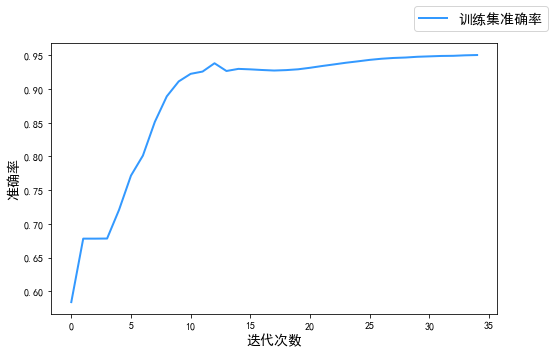

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(8, 5))

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置

x=np.arange(35)
ax1.plot(x, model.train_accuracy, '-', color='#3399ff', linewidth=2,label='训练集准确率')
ax1.set_ylabel('准确率',fontsize=14)

lines = []
labels = []

for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

fig.legend(lines, labels,loc = 'upper right',frameon=True,fontsize=14)

ax1.set_xlabel('迭代次数',fontsize=14)
plt.show()

# 测试

In [26]:
model.loadParmetrs()
test_Accuary, pre_y2 = model.predict(test_data, test_lab)
realy_pro_y=[]
for j in range(len(test_lab)):
    if (test_lab[j] >= 124):
        realy_pro_y.append(1)
    else:
        realy_pro_y.append(0)

In [27]:
realy_pro_y=realy_pro_y[:116640]
y_pred=(np.array(pre_y2).flatten())
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [28]:
test_auc=calAUC(np.array(realy_pro_y),y_pred)

0.7245295225199567


In [32]:
print("测试集准确率为：%.5f "%test_Accuary)
print(" ")
print("测试集AUC为：%.5f "%test_auc)

测试集准确率为：0.73715 
 
测试集AUC为：0.72453 


# 再增加训练迭代次数很容易梯度爆炸，

# 或许减小时间步，增加迭代次数，减小学习率，或梯度裁剪可以再提高模型的性能